# Extracting data


RESOURCE: https://sites.northwestern.edu/researchcomputing/2022/01/04/plotting-geospatial-data-with-python/

Original file: fullAnaphylaxisCohort.csv

Geocoding command: docker run --rm -v $PWD:/tmp ghcr.io/degauss-org/geocoder:3.3.0 fullAnaphylaxisCohort.csv

New file: fullAnaphylaxisCohort_geocoder_3.3.0_score_threshold_0.5.csv

In [3]:
print("Hello world!")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("Packages imported!")

Hello world!
Packages imported!


In [4]:
cohort = pd.read_csv("fullAnaphylaxisCohort_geocoder_3.3.0_score_threshold_0.5.csv")
print(np.shape(cohort))
print(cohort.columns)

(10000, 16)
Index(['address_1', 'address_2', 'givenCity', 'givenState', 'givenZip',
       'street_address', 'address', 'matched_street', 'matched_zip',
       'matched_city', 'matched_state', 'lat', 'lon', 'score', 'precision',
       'geocode_result'],
      dtype='object')


(9610, 16)
count    9610.000000
mean        0.902936
std         0.079881
min         0.500000
25%         0.881000
50%         0.941000
75%         0.949000
max         1.000000
Name: score, dtype: float64


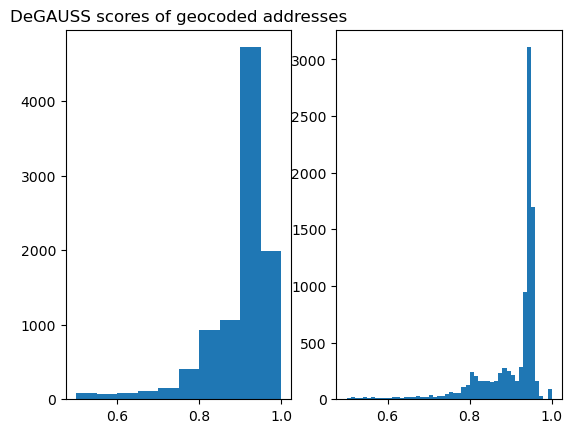

In [5]:
cohort = cohort[cohort['geocode_result'] == 'geocoded']
cohort = cohort[cohort['lat'].notnull()]
print(np.shape(cohort))
print(cohort['score'].describe())

fig, axs = plt.subplots(1,2)
axs[0].hist(cohort['score'], bins = 10)
axs[1].hist(cohort['score'], bins = 50)
axs[0].set_title("DeGAUSS scores of geocoded addresses")

plt.show()

In [6]:
THRESHOLD = 0.8
filtered_cohort = cohort[cohort['score'] > THRESHOLD]
np.shape(filtered_cohort)

(8667, 16)

In [7]:
state_series = filtered_cohort.groupby("matched_state")["lat"].count()
state_table = pd.DataFrame({'state':state_series.index, 'count':state_series.values})
print(state_table.sort_values('count', ascending=False)[0:5])

   state  count
20    MO   6729
11    IL   1645
35    TX     20
2     AR     18
12    IN     18


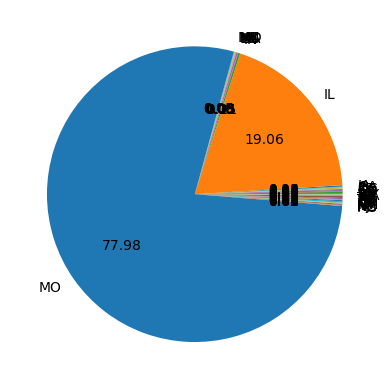

In [8]:
plt.pie(state_table['count'], 
        labels = state_table['state'], 
        autopct='%.2f')

plt.show()

# Geo-plotting

In [9]:
import plotly.express as px
import plotly.graph_objects as go
print("Installing more packages!")

Installing more packages!


In [10]:
fig = go.Figure(data=go.Scattergeo(
    lon = np.round(filtered_cohort['lon'], 1),
    lat = np.round(filtered_cohort['lat'], 1),
    text = "[Rounded coordinates], Score: " + (filtered_cohort['score']).astype('str'),
    mode = 'markers',
    marker = dict(
        line = dict(width=1, color='rgba(0, 0, 0)'),
        color = filtered_cohort['score'],
        colorbar_title="DeGAUSS Score"
    )
))

fig.update_layout(
    title = 'Filtered Anaphylaxis Cohort (>80% geocoding match)',
    geo_scope='usa',
)
fig.show()

fig.write_image('anaphylaxisScatterplot.png')


In [9]:
fig = px.choropleth(data_frame=state_table, 
                    locations='state',
                    locationmode="USA-states", 
                    color='count', 
                    scope="usa")
 
fig.show()

# County-level geoplotting

Based on the above plots, it makes more sense to just focus on Missouri and Illinois.

In [11]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
gdf = gpd.read_file('shp/usCounties/tl_2020_us_county.shp')
print("More packages!")

More packages!


In [12]:
moil_cohort = filtered_cohort[filtered_cohort['matched_state'].isin(['MO', 'IL'])]
np.shape(moil_cohort)

(8374, 16)

In [13]:
moil_gdf = gdf[gdf['STATEFP'].isin(['17', '29'])].reset_index()
print(np.shape(moil_gdf))

(217, 19)


**WARNING:** the shapefile stores coordinates in (Longitude, Latitude)
- This makes sense from a (x,y) perspective. 
- However, convention (ex. Google Maps) is (Latitude, Longitude)

In [14]:
found = 0
total = 0
addressesInGeom = np.zeros(len(moil_gdf))

# This loop takes about 56 seconds to run
for i, address in moil_cohort.iterrows():
    coord = Point(address['lon'], address['lat'])
    total += 1
    
    for j, row in moil_gdf.iterrows():
        if row['geometry'].contains(coord):
            found += 1
            addressesInGeom[j] += 1
    
    if total % 1000 == 0:
        print(found, total)      

1000 1000
2000 2000
3000 3000
4000 4000
5000 5000
6000 6000
7000 7000
8000 8000


In [19]:
moil_gdf['numAddr'] = addressesInGeom.astype(int)
moil_gdf['repPoint'] = moil_gdf['geometry'].apply(lambda x: x.representative_point().coords[:][0])
moil_gdf[moil_gdf['numAddr'] > 1000].sample(2)

,index,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,numAddr,repPoint
213,3141,29,510,00767557,29510,St. Louis,St. Louis city,25,C7,G4020,...,41180,None,F,159895650,11563208,+38.6356988,-090.2445816,"POLYGON ((-90.32052 38.59415, -90.32050 38.594...",1157,"(-90.24101427282157, 38.652899)"
101,1478,29,183,00758546,29183,St. Charles,St. Charles County,06,H1,G4020,...,41180,None,A,1451692101,82663655,+38.7811023,-090.6749153,"POLYGON ((-90.96100 38.81746, -90.96099 38.817...",1023,"(-90.7275926985842, 38.751239999999996)"


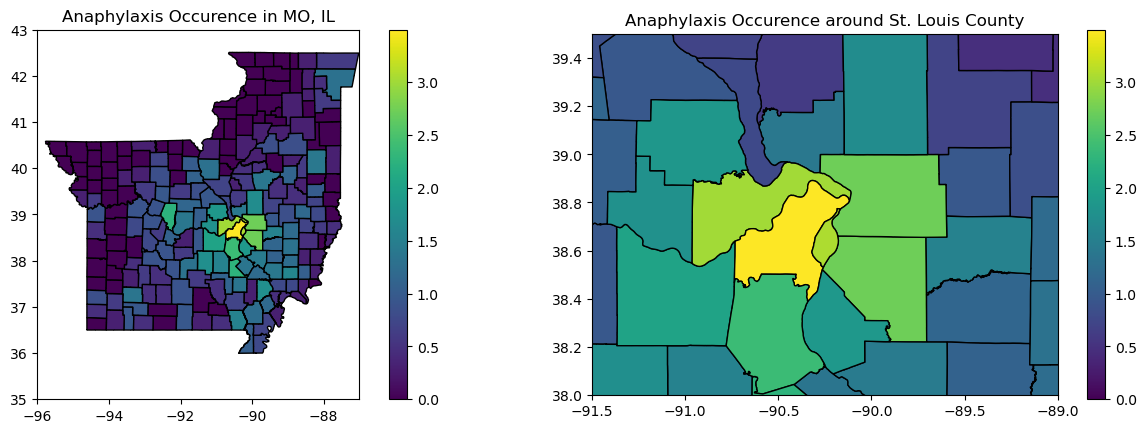

<Figure size 640x480 with 0 Axes>

In [21]:
window1 = [[-96,-87], [35,43]]
window2 = [[-91.5,-89], [38,39.5]]
moil_gdf['logAddr'] = np.log10(moil_gdf['numAddr'] + 1)

fig, axs = plt.subplots(1, 2)

axs[0].set_title("Anaphylaxis Occurence in MO, IL")
axs[0].set_xlim(window1[0])
axs[0].set_ylim(window1[1])
moil_gdf.plot(column = "logAddr", edgecolor="black", legend=True, ax = axs[0])

axs[1].set_title("Anaphylaxis Occurence around St. Louis County")
axs[1].set_xlim(window2[0])
axs[1].set_ylim(window2[1])
moil_gdf.plot(column = "logAddr", edgecolor="black", legend=True, ax = axs[1])

plt.subplots_adjust(left = 3, right = 5)
plt.show()

plt.savefig('anaphylaxisCountyPlot.png')

Again, not very helpful — most hospital patients are from within St. Louis County.

# Tract-level geoplotting

Tracts would be more helpful. 

Shapefile source: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

In [22]:
mo_gdf = gpd.read_file('shp/moTracts/tl_2023_29_tract.shp')
il_gdf = gpd.read_file('shp/ilTracts/tl_2023_17_tract.shp')
print("Tract files!")

Tract files!


In [23]:
print(np.shape(mo_gdf))
mo_gdf.sample(1)

(1654, 14)


,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
1547,29,183,311148,29183311148,1400000US29183311148,3111.48,Census Tract 3111.48,G5020,S,18044277,2319549,+38.7012752,-090.5528628,"POLYGON ((-90.58142 38.71046, -90.58061 38.710..."


In [24]:
print(np.shape(il_gdf))
il_gdf.sample(1)

(3265, 14)


,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
2236,17,197,881009,17197881009,1400000US17197881009,8810.09,Census Tract 8810.09,G5020,S,7652955,44109,+41.5757865,-088.0172751,"POLYGON ((-88.02631 41.59778, -88.02594 41.597..."


In [25]:
found = 0
total = 0
moCounts = np.zeros(len(mo_gdf))
ilCounts = np.zeros(len(il_gdf))

# This takes 9 minutes to run
for i, address in moil_cohort.iterrows():
    coord = Point(address['lon'], address['lat'])
    total += 1

    if address['matched_state'] == 'MO':
        for j, row in mo_gdf.iterrows():
            if row['geometry'].contains(coord):
                found += 1
                moCounts[j] += 1
    
    else:
        for j, row in il_gdf.iterrows():
            if row['geometry'].contains(coord):
                found += 1
                ilCounts[j] += 1
    
    if total % 1000 == 0:
        print(found, total)

989 1000
1966 2000
2960 3000
3946 4000
4936 5000
5927 6000
6915 7000
7906 8000


In [32]:
mo_gdf['numAddr'] = moCounts.astype(int)
il_gdf['numAddr'] = ilCounts.astype(int)
moil_tract_gdf = pd.concat([mo_gdf, il_gdf], axis=0)

moil_tract_gdf['repPoint'] = moil_tract_gdf['geometry'].apply(lambda x: x.representative_point().coords[:][0])
moil_tract_gdf[moil_tract_gdf['numAddr'] > 30].sample(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,numAddr,repPoint
1143,29,189,210912,29189210912,1400000US29189210912,2109.12,Census Tract 2109.12,G5020,S,18225481,715370,+38.8281979,-090.2621262,"POLYGON ((-90.30972 38.82594, -90.30763 38.826...",40,"(-90.26472185049019, 38.8336745)"
1002,29,189,217500,29189217500,1400000US29189217500,2175,Census Tract 2175,G5020,S,13276014,18968,+38.6230215,-090.3882698,"POLYGON ((-90.40623 38.60453, -90.40621 38.605...",32,"(-90.3841545987095, 38.6217465)"


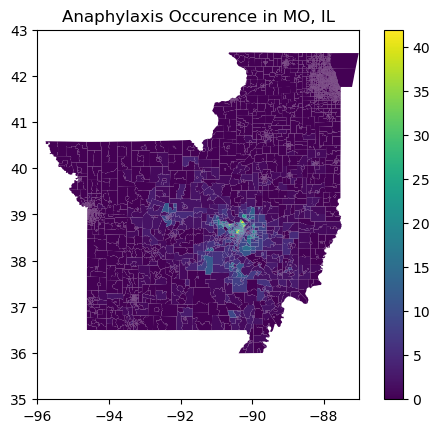

In [33]:
window1 = [[-96,-87], [35,43]]

fig, axs = plt.subplots(1, 1)

ax_state = axs
ax_state.set_title("Anaphylaxis Occurence in MO, IL")
ax_state.set_xlim(window1[0])
ax_state.set_ylim(window1[1])
moil_tract_gdf.plot(column = "numAddr", legend=True, ax = ax_state)

plt.show()

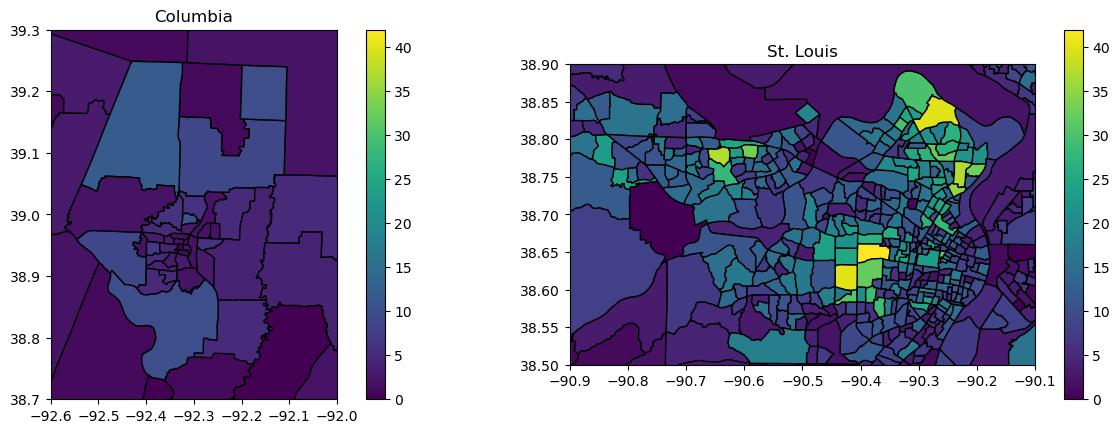

<Figure size 640x480 with 0 Axes>

In [35]:
window2 = [[-90.9,-90.1], [38.5,38.9]]
window3 = [[-92.6,-92], [38.7,39.3]]

fig, axs = plt.subplots(1, 2)

ax_col = axs[0]
ax_col.set_title("Columbia")
ax_col.set_xlim(window3[0])
ax_col.set_ylim(window3[1])
moil_tract_gdf.plot(column = "numAddr", edgecolor="black", legend=True, ax = ax_col)

ax_stl = axs[1]
ax_stl.set_title("St. Louis")
ax_stl.set_xlim(window2[0])
ax_stl.set_ylim(window2[1])
moil_tract_gdf.plot(column = "numAddr", edgecolor="black", legend=True, ax = ax_stl)

plt.subplots_adjust(left = 3, right = 5)
plt.show()

plt.savefig('anaphylaxisTractPlot.png')